In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# # filter only test playersex
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

1187

In [25]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661




### preprocessing with pipelines

In [26]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info
from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [27]:
inplace_ffill_features = ['numberOfFollowers',
                          'teamFollowers',
                          'status',
                          'teamId',
                          'rosterDate',
                          'pstatsDate']

In [28]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features,
                                                        'on': ['playerId', 'year']})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [29]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('hardcoded_feat', harcoded_feat_tmf)])

In [30]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [31]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName',
              'status', 'teamId', 'weekday',
              'opponentTeamId', 'birthCountry']

In [32]:
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [33]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[30], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


target_stats_table.head()

,playerId,date,target1__mean__30d,target1__median__30d,target1__std__30d,target2__mean__30d,target2__median__30d,target2__std__30d,target3__mean__30d,target3__median__30d,target3__std__30d,target4__mean__30d,target4__median__30d,target4__std__30d
0,405395,2018-01-01,0.151872,0.151872,NaN,21.449417,21.449417,NaN,0.112952,0.112952,NaN,22.990196,22.990196,NaN
1,405395,2018-01-02,0.144139,0.144139,0.010936,16.214001,16.214001,7.403996,0.104677,0.104677,0.011702,19.329685,19.329685,5.176745
2,405395,2018-01-03,0.117580,0.136406,0.046648,13.884730,10.978585,6.609544,0.103606,0.101464,0.008480,20.610733,22.990196,4.280490
3,405395,2018-01-04,0.094239,0.100433,0.060248,12.956289,10.574775,5.707194,0.103317,0.101956,0.006948,24.297829,23.081512,8.160501
4,405395,2018-01-05,0.106902,0.136406,0.059365,11.223893,10.170965,6.279732,0.091957,0.101464,0.026104,21.907820,22.990196,8.860362


In [34]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[45], clip_max=True)),
                                 ('fillnan', FunctionTransformer(fillna)),
                                 ('normalize', PdScaleNorm())
                                ])

In [35]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [36]:
from pipeline.core import FilterFeatures

In [37]:
player_tv_cont_features = FilterFeatures(['runsScored__ptvf', 'homeRuns__ptvf',
                                          'hits__ptvf', 'SLG__ptvf',
                                          'rbi__ptvf',
                                          'plateAppearances__ptvf',
                                          'runsPitching__ptvf',
                                           'playerId', 'date']).fit(df)._features

In [38]:
player_tv_cont_features

['playerId',
 'date',
 'runsScored__ptvf',
 'homeRuns__ptvf',
 'hits__ptvf',
 'plateAppearances__ptvf',
 'rbi__ptvf',
 'runsPitching__ptvf',
 'SLG__ptvf']

In [39]:
## moving stats for players stats
# get the rest of the continuous features
stats_gen_cont_features = StatisticGen(stats=['sum', 'max'],
                             windows=[7],
                             drop_index=True)
_mov_cont_feat_tmf = Pipeline([('fillnan', FunctionTransformer(fillna)),
                               ('cont_stats', stats_gen_cont_features),
                                ('normalize', PdScaleNorm()),
                                ])
mov_cont_feat_tmf = PdColumnTransformer([('cont', _mov_cont_feat_tmf, player_tv_cont_features)]
                                 )

In [40]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                   ('cats', categories_tmf),
                                   ('mov_feat', mov_cont_feat_tmf),
                                  ])

In [41]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [42]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fa0d2f508b0>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

### modeling 

In [43]:
from omegaconf import OmegaConf
hp = {}
# real_data_config = OmegaConf.create(real_data_config)

In [44]:
from train.lgbm import run_lgbm

In [45]:
def filter_by_idx(df, idx):
    return df.loc[idx, :].reset_index(drop=True)

In [46]:
parameters = {'objective':'mae',
           'reg_alpha': 0.14947461820098767, 
           'reg_lambda': 0.10185644384043743, 
           'n_estimators': 3633, 
           'learning_rate': 0.08046301304430488, 
           'num_leaves': 674, 
           'feature_fraction': 0.9101240539122566, 
           'bagging_fraction': 0.9884451442950513, 
           'bagging_freq': 8, 
           'min_child_samples': 51}


In [47]:
df.drop([f for f in df.columns if 'atInning' in f], axis=1, inplace=True)

In [48]:
test_dates = ['2021-04-01', '2021-05-01',
              '2021-06-01', '2021-07-01',
              '2021-08-01']
output = []

cv_prediction = []
for start_test_date, end_test_date in zip(test_dates[:-1], test_dates[1:]):
    train_idx = df['date'] < start_test_date
    valid_idx = df['date'].between(start_test_date, end_test_date, inclusive=False)
    
    print(f'evaluating from {start_test_date} to {end_test_date}')
    
    print('training pipeline')
    pipeline.fit(filter_by_idx(df, train_idx))
    print('executing pipeline')
    features = pipeline.transform(df)
    features_list = features.columns.to_list()
    train_data = filter_by_idx(features, train_idx)
    valid_data = filter_by_idx(features, valid_idx)
    # add the target to features ds
    train_data[target_cols + ['date']] = df.loc[train_idx, target_cols + ['date']].to_numpy()
    valid_data[target_cols + ['date']] = df.loc[valid_idx, target_cols + ['date']].to_numpy()
    
    
    config_hp = {'hp': parameters,
                 'features': features_list,
                  'categories': categories,
                  'target_cols': target_cols}
    config_hp = OmegaConf.create(config_hp)
    fold_output = run_lgbm(config_hp, train_data, valid_data)
    
    _prediction = fold_output.prediction[:]

    fold_prediction = pd.DataFrame(_prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])
    
    fold_prediction[pp_cols] = df.loc[valid_idx, pp_cols].to_numpy()
    output.append(fold_output)
    cv_prediction.append(fold_prediction)

evaluating from 2021-04-01 to 2021-05-01
training pipeline
executing pipeline
target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['birthCountry', 'opponentTeamId', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.19306
[200]	valid_0's l1: 1.18888
[300]	valid_0's l1: 1.18802
Early stopping, best iteration is:
[278]	valid_0's l1: 1.18744
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 2.33503
Early stopping, best iteration is:
[87]	valid_0's l1: 2.33258
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.935737
Early stopping, best iteration is:
[28]	valid_0's l1: 0.929763
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.58866
Early stopping, best iteration is:
[34]	valid_0's l1: 1.58351
evaluating from 2021-05-01 to 2021-06-01
training pipeline
executing pipeline
target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['birthCountry', 'opponentTeamId', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.09412
[200]	valid_0's l1: 1.09074
Early stopping, best iteration is:
[194]	valid_0's l1: 1.09072
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 2.17522
[200]	valid_0's l1: 2.16977
Early stopping, best iteration is:
[166]	valid_0's l1: 2.1647
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.874379
Early stopping, best iteration is:
[6]	valid_0's l1: 0.854872
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.35004
Early stopping, best iteration is:
[15]	valid_0's l1: 1.2339
evaluating from 2021-06-01 to 2021-07-01
training pipeline
executing pipeline
target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['birthCountry', 'opponentTeamId', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.994996
[200]	valid_0's l1: 0.991955
[300]	valid_0's l1: 0.991065
[400]	valid_0's l1: 0.990807
[500]	valid_0's l1: 0.9902
[600]	valid_0's l1: 0.989687
Early stopping, best iteration is:
[568]	valid_0's l1: 0.989495
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.75241
[200]	valid_0's l1: 1.75439
Early stopping, best iteration is:
[117]	valid_0's l1: 1.75033
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.797386
[200]	valid_0's l1: 0.798907
Early stopping, best iteration is:
[107]	valid_0's l1: 0.797039
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.40846
[200]	valid_0's l1: 1.40093
[300]	valid_0's l1: 1.39845
[400]	valid_0's l1: 1.39877
Early stopping, best iteration is:
[371]	valid_0's l1: 1.39801
evaluating from 2021-07-01 to 2021-08-01
training pipeline
executing pipelin

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['birthCountry', 'opponentTeamId', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.893776
[200]	valid_0's l1: 0.892982
[300]	valid_0's l1: 0.891824
Early stopping, best iteration is:
[277]	valid_0's l1: 0.8916
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.33222
Early stopping, best iteration is:
[16]	valid_0's l1: 1.28864
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.709682
[200]	valid_0's l1: 0.709158
Early stopping, best iteration is:
[110]	valid_0's l1: 0.707846
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.80562
Early stopping, best iteration is:
[8]	valid_0's l1: 0.618379


In [49]:
cv_prediction = pd.concat(cv_prediction, axis=0, ignore_index=True)

In [50]:
# from train.core import Ensemble, predict_recursive
# ensemble = Ensemble([output], pipeline)

In [51]:
# %%time
# raw_train_fr = raw_train_df[df.columns].copy()

# recursive_prediction = []
# for date, val_date_df in raw_valid_df.groupby('date'):
#     val_date_df = val_date_df[df.columns].reset_index(drop=True)
#     _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
#                                                      raw_train_fr,
#                                                      ensemble,
#                                                      n_days=90 + 60 + 10,
#                                                      target_cols=target_cols)
#     recursive_prediction.append(_recurive_pred)

# recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
# recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
# recursive_prediction.reset_index(drop=True, inplace=True)
# recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
#                                      for f in target_cols}, inplace=True)
# recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

In [52]:
from evaluate.metrics import compute_metrics

In [53]:
# last_mean_prediction = (raw_valid_df.set_index('date').groupby(['playerId'])[target_cols]
#                         .rolling(window=7, min_periods=1).mean().reset_index())
# last_mean_prediction

# hardest_ids = [660271]
# hardest_idx = raw_valid_df['playerId'].isin(hardest_ids)

# yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']
# valid_test_prediction_with_last_mean = valid_test_prediction.copy(deep=True)
# valid_test_prediction_with_last_mean.loc[hardest_idx, yhat_cols] = last_mean_prediction.loc[hardest_idx, target_cols].to_numpy()

# valid_test_prediction_with_last_mean

In [54]:
# valid_test_prediction.loc[hardest_idx].head()

In [55]:
# valid_test_prediction_with_last_mean.loc[hardest_idx].head()

In [56]:
# raw_cv_prediction = cv_prediction.copy(deep=True)

In [57]:
cv_prediction = filter_by_id(cv_prediction, player_in_test)

In [58]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(cv_prediction)

{'mae_mean': 1.2848699975555187,
 'mae_1': 1.0588297145041186,
 'mae_2': 1.961188915355701,
 'mae_3': 0.8370092441478056,
 'mae_4': 1.2824521162144495}

In [59]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(valid_test_prediction_with_last_mean)

In [60]:
(cv_prediction.groupby(cv_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,1.508322,1.187440,2.332581,0.929763,1.583505
5,1.336047,1.090719,2.164697,0.854872,1.233900
6,1.233719,0.989495,1.750332,0.797039,1.398011
7,0.876617,0.891600,1.288641,0.707846,0.618379


In [61]:
# (valid_test_prediction_with_last_mean.groupby(valid_test_prediction.date.dt.month)
#  .apply(lambda x: pd.Series(compute_metrics(x))))

In [62]:
# (april_set_with_last_mean.groupby(['playerId'])
#  .apply(lambda x: pd.Series(compute_metrics(x)))
#  .sort_values(by='mae_mean', ascending=False))

In [63]:
(cv_prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,37.485539,25.026168,37.752844,41.244723,45.918420
594798,20.403271,12.038039,25.823821,19.364472,24.386754
665487,18.288757,16.452042,11.570455,22.458835,22.673694
665489,14.318415,17.753755,15.267907,12.253300,11.998696
405395,13.739930,8.430253,11.393404,10.086433,25.049629
...,...,...,...,...,...
683232,0.061927,0.000380,0.112394,0.008979,0.125955
680430,0.060461,0.000590,0.174130,0.001345,0.065777
663992,0.059376,0.009698,0.120342,0.014209,0.093255


In [64]:
hardest_id = filter_by_id(cv_prediction, [660271])

In [65]:
(hardest_id.groupby(['playerId', hardest_id.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     71.360408  51.906144  71.843348  65.913046  95.779093
         5     33.955930  23.214639  33.023385  39.754523  39.831173
         6     32.328304  18.687975  32.593076  38.856538  39.175627
         4     27.604510  18.408023  28.996602  31.564386  31.449028

In [66]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [67]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [68]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [69]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

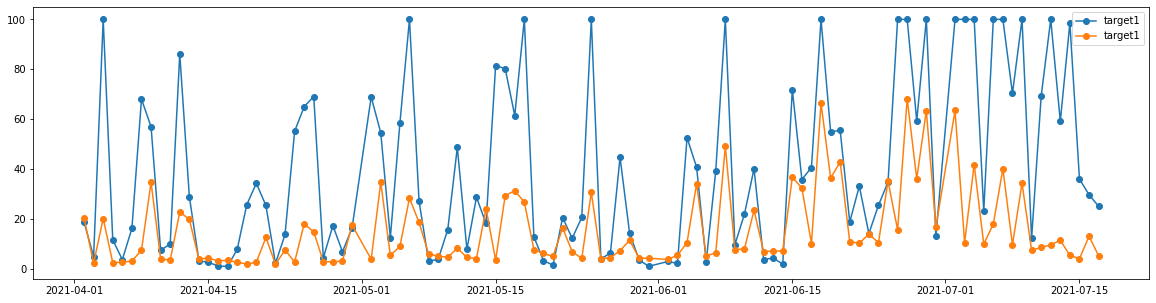

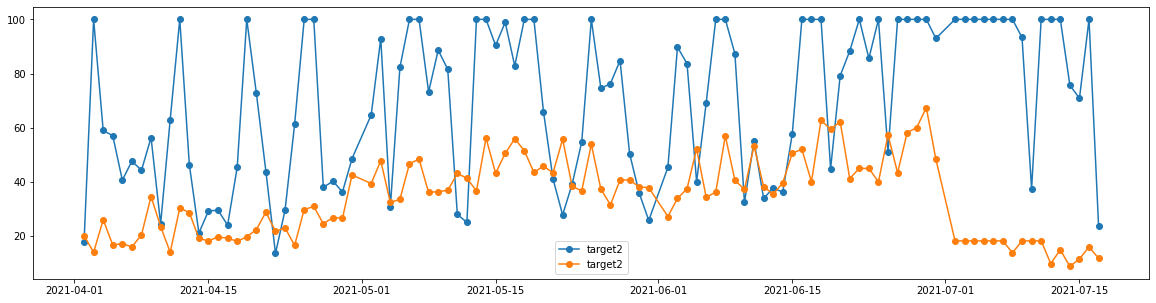

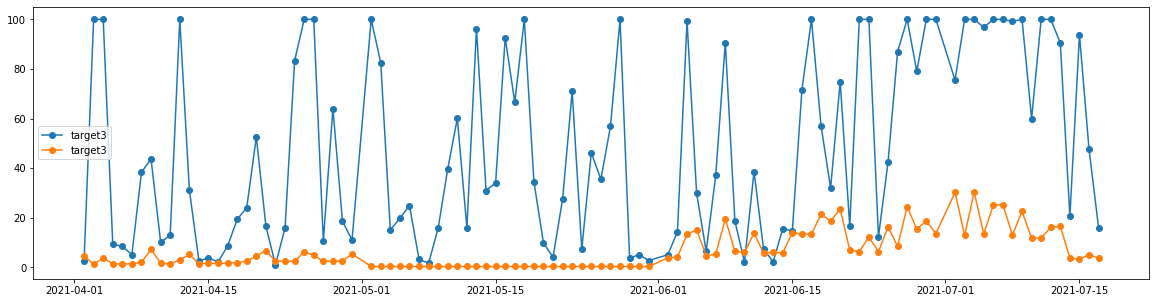

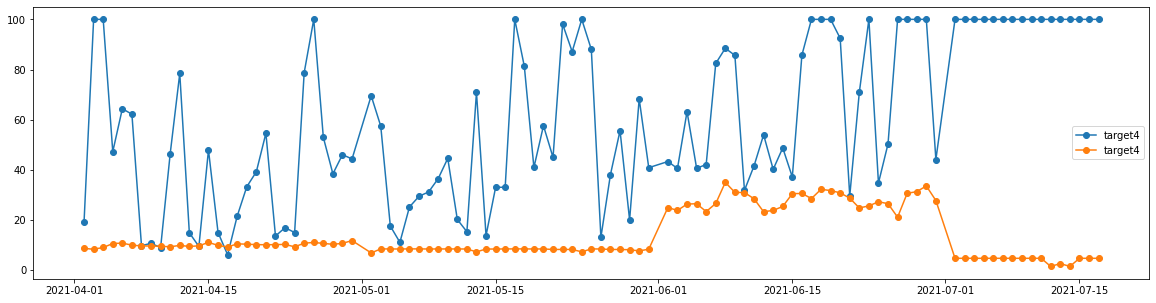

In [70]:
for index in range(1, 5):
    plot_pred(hardest_id, playerId=660271, index=index)